In [1]:
# Load data
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import project_env
from imp import reload
import math
import os
import run_logreg

reload(project_env)

%matplotlib inline

In [2]:
'''Loads and Processes Stations.Json file'''

with open('stations.json') as data_file:    
    data = json.load(data_file)
stations = pd.read_json('stations.json', 'index').T
stations_df = pd.DataFrame.from_dict(stations['stationBeanList'][0], orient = 'index').T
for i in range(1, 664):
    stations_df = pd.concat([stations_df, pd.DataFrame.from_dict(stations['stationBeanList'][i], orient = 'index').T])
stations_df = stations_df.set_index('id')

files = os.listdir('per_station_dev')

station_ids = []
for i in range(0, len(files)):
    station_ids.append(int(files[i][0:len(files[i])- 4]))
    
stations_df = stations_df.loc[station_ids, :]

stations_df.head()

,stAddress1,postalCode,altitude,landMark,city,location,longitude,testStation,stationName,latitude,statusKey,totalDocks,statusValue,availableDocks,lastCommunicationTime,stAddress2,availableBikes
id,,,,,,,,,,,,,,,,,
128,MacDougal St & Prince St,,,,,,-74.003,False,MacDougal St & Prince St,40.7271,1,30,In Service,27,2016-12-03 12:51:57 PM,,3
151,Cleveland Pl & Spring St,,,,,,-73.9972,False,Cleveland Pl & Spring St,40.7221,1,33,In Service,7,2016-12-03 12:54:56 PM,,26
161,LaGuardia Pl & W 3 St,,,,,,-73.9981,False,LaGuardia Pl & W 3 St,40.7292,1,35,In Service,0,2016-12-03 12:51:54 PM,,33
174,E 25 St & 1 Ave,,,,,,-73.9774,False,E 25 St & 1 Ave,40.7382,1,30,In Service,25,2016-12-03 12:53:39 PM,,3
229,Great Jones St,,,,,,-73.9938,False,Great Jones St,40.7274,1,23,In Service,1,2016-12-03 12:53:21 PM,,21


In [3]:
import math

def distance(station_a_id, station_b_id):
    longitude_difference = stations_df.loc[station_a_id, 'longitude'] - stations_df.loc[station_b_id, 'longitude']
    latitude_difference = stations_df.loc[station_a_id, 'latitude'] - stations_df.loc[station_b_id, 'latitude']
    distance = math.sqrt(longitude_difference**2 + latitude_difference**2)
    return distance

In [4]:
def closest_stations(station_a_id, num):
    distances = pd.Series(data=None, index = stations_df.index)
    for station_id in stations_df.index:
        distances[station_id] = distance(station_a_id, station_id)
    distances = distances.sort_values()
    return distances.iloc[1:num+1]   

In [5]:
closest_stations(128, 5)

id
368    0.003384
161    0.005289
151    0.007598
383    0.008572
229    0.009187
dtype: float64

**The `project_env` package**

I wrote this python package so loading and working with data is quicker and easier. There are several convenience methods:
* `load_split_bucket(station_id)` - Load data for a bike station that's already pre-split into train, dev and test. Includes doing data cleaning and thresholding. The output is a dictionary:
```
  {
    'train': (DataFrame, Series),
    'dev': (DataFrame, Series),
    'test': (DataFrame, Series)
  }
```
  Each `(DataFrame, Series)` tuple is the feature values and target variables, respectively.
* `merge_training(split, df)` - Given two outputs of `load()`, append the training set of the second argument to the training set of the first. This is useful when trying to load data from multiple stations, but testing on one station only.
* `binarize(data, target)` - Given output of `load()` and either 1 or -1, binarize the target variable to 0 or 1. Whatever class is in the second argument will become '1' in the new data.

**The `run_logreg` package**

We wrote this python package so running many logistic regression models with different parameters is cleaner and easier. Here are the methods included in the file:

* `do_logreg` - Takes the result of split_data and performs a logistic regression given the input parameters. It takes a parameters called "squares" that will perform some basic feature engineering by squaring some of the variables, a penalty function (l1 or l2, defaults to l2), and a c parameter (defaults to 100,000).

In [6]:
data = project_env.load_split_bucket(519, target='y_60m', log=False)
print('done loading')

done loading


In [7]:
def read_more_data(station_id, target):
    return project_env.load_split_bucket(station_id, target=target)

def add_closest_stations(split_data, station_id, target, num_stations=10, empty=True):
    '''takes split_data for one station and its station_id, splits, merges the closest stations' data and binarizes all'''
    station_ids_to_concat = list(closest_stations(station_id, num_stations).index[0:num_stations])
    station_ids_data = [read_more_data(sid, target) for sid in station_ids_to_concat]
    appended_multiple = split_data
    for df in station_ids_data:
        appended_multiple = project_env.merge_training(appended_multiple, df)
    binary = (empty==True)*-1 + (empty!=True)*1
    appended_multiple = project_env.binarize(appended_multiple, binary)
    return appended_multiple

In [24]:
def run_models(data, station_id, target, basic=True, append_one=True, append_multiple=False, squares=True, empty=True):
    '''Create a function that creates a dictionary of models based on inputs'''
    
    if empty == True:
        data_binarized = project_env.binarize(data, -1)
    elif empty == False:
        data_binarized = project_env.binarize(data, 1)
    
    keys = ['basic', 'append_one', 'append_multiple', 'squares']
    parameters = [basic, append_one, append_multiple, squares]
    keys_chosen = []
    
    for i in range(0, len(keys)):
        if parameters[i] == True:
            keys_chosen.append(keys[i])
    
    logregs = {}
    scalers = {}
    predictions = {}
    
    if 'basic' in keys_chosen:
        logregs['basic'], scalers['basic'], predictions['basic'] = run_logreg.do_logreg(data_binarized, plot = False)
    if 'append_one' in keys_chosen:
        appended_one = add_closest_stations(data, station_id, target, num_stations=1, empty=empty)
        logregs['append_one'], scalers['append_one'], predictions['append_one'] = run_logreg.do_logreg(appended_one, plot = False)
    if 'append_multiple' in keys_chosen:
        appended_multiple = add_closest_stations(data, station_id, target, num_stations=10, empty=empty)
        logregs['append_multiple'], scalers['append_multiple'], predictions['append_multiple'] = run_logreg.do_logreg(appended_multiple, plot = False)
    if 'squares' in keys_chosen:
        logregs['squares'], scalers['squares'], predictions['squares'] = run_logreg.do_logreg(data_binarized, squares=True, plot = False)
        
    return logregs, scalers, predictions

In [33]:
'''Run empty models'''
data = project_env.load_split_bucket(519, target='y_60m', log=False)

logregs_e, scalers_e, predictions_e = run_models(data, 519, 'y_60m')

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.810950413223
[[443 142]
 [ 41 342]]
X shape: (7360, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.778925619835
[[424 161]
 [ 53 330]]
X shape: (4236, 44)
Evaluating on dev set of 968 examples
Accuracy: 0.601239669421
[[222 363]
 [ 23 360]]


In [26]:
'''Run full models'''

data = project_env.load_split_bucket(519, target='y_60m', log=False)

#something's wrong here the appended ones are doing weird stuff

logregs_f, scalers_f, predictions_f = run_models(data, 519, 'y_60m', empty=False)

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.95041322314
[[920   0]
 [ 48   0]]
X shape: (7360, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.95041322314
[[920   0]
 [ 48   0]]
X shape: (4236, 44)
Evaluating on dev set of 968 examples
Accuracy: 0.949380165289
[[919   1]
 [ 48   0]]


# Evaluation

Plot the precision-recall curve for the 4 classifiers:

#### 95% Recall

95% recall means that whenever the model tells a user to go to a station to pick up a bike at a designated time, 5% of the time, the station ends up empty (the bad case).

Given a model satisfies at least 95% recall, a higher precision means fewer occasions where a model turns the user away from the station even though it has bikes available (a more efficient model). So, we want to find a model that maximizes precision given a minimum recall.

In the plot above the `basic` model wins out at around 57% precision at 95% recall. So that means when the model says the station is empty, 57% of the time the station will actually be empty.

#### Empty

In [13]:
def format_plot(target_recall, empty=True):
    if empty==True:
        plt.xlim([0.9, 1.0])
        plt.ylim([0.4, 0.7])
    if empty==False:
        plt.xlim([0.9, 1.0])
        plt.ylim([0, 0.7])
    plt.axvline(x=target_recall, color='k', linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.title('Precision-Recall Curves')
    

Model baseline
  Max precision: 0.528301886792 at recall 0.950391644909
  Threshold of max precision: 0.540983606557
Model append_one
  Max precision: 0.530523255814 at recall 0.953002610966
  Threshold of max precision: 0.121865585866
Model squares
  Max precision: 0.480895915679 at recall 0.953002610966
  Threshold of max precision: 0.387572925669
Model basic
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237075253857


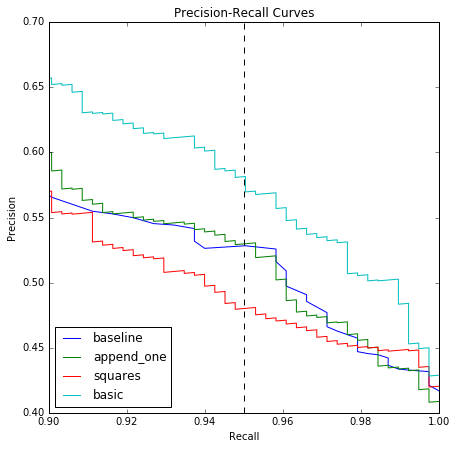

In [18]:
from sklearn.metrics import precision_recall_curve

data_empty = data_binarized = project_env.binarize(data, -1)
gold_labels = data_empty['dev'][1]

'''modified pr_curve function to take "gold_labels" AND the threshold as a parameter'''
def pr_curve(predictions, label, gold_labels, target_recall=0.95):
    curve = precision_recall_curve(gold_labels, predictions)
    precision, recall, thresholds = curve
    mp, mr, mt = project_env.max_precision_for_recall(curve, target_recall=target_recall)
    print('Model', label)
    print('  Max precision:', mp, 'at recall', mr)
    print('  Threshold of max precision:', mt)
    plt.plot(recall, precision, label=label)
   
plt.figure(figsize=(7, 7))
pr_curve(data_empty['dev'][0]['num_docks_available_scaled'], 'baseline', gold_labels, target_recall=0.95)
for key in predictions_e.keys():
    pr_curve(predictions_e[key], key, gold_labels, target_recall=0.95)

format_plot(.95)
plt.show()

#### Full

Model baseline
  Max precision: 0.0496380558428 at recall 1.0
  Threshold of max precision: 0.016393442623
Model append_one
  Max precision: 0.380165289256 at recall 0.958333333333
  Threshold of max precision: 0.00829529733758
Model squares
  Max precision: 0.0538373424971 at recall 0.979166666667
  Threshold of max precision: 2.45502138432e-08
Model basic
  Max precision: 0.319444444444 at recall 0.958333333333
  Threshold of max precision: 0.0084663560742


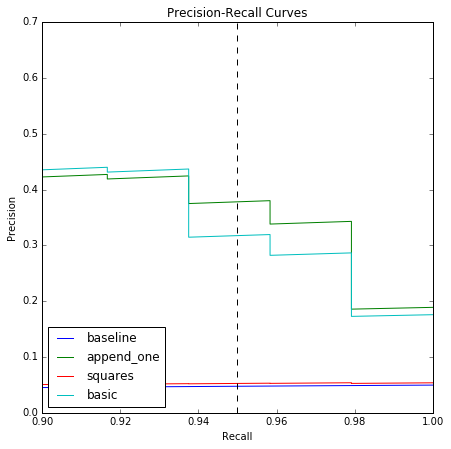

In [28]:
data_full = data_binarized = project_env.binarize(data, 1)
gold_labels = data_full['dev'][1]
   
plt.figure(figsize=(7, 7))
pr_curve(data_full['dev'][0]['num_docks_available_scaled'], 'baseline', gold_labels, target_recall=0.95)
for key in predictions_f.keys():
    pr_curve(predictions_f[key], key, gold_labels, target_recall=0.95)

format_plot(.95, empty=False)


#### 85% Recall

Model baseline
  Max precision: 0.629001883239 at recall 0.872062663185
  Threshold of max precision: 0.770491803279
Model append_one
  Max precision: 0.695095948827 at recall 0.851174934726
  Threshold of max precision: 0.543670600229
Model squares
  Max precision: 0.665306122449 at recall 0.851174934726
  Threshold of max precision: 0.879322558173
Model basic
  Max precision: 0.781774580336 at recall 0.851174934726
  Threshold of max precision: 0.637375427873


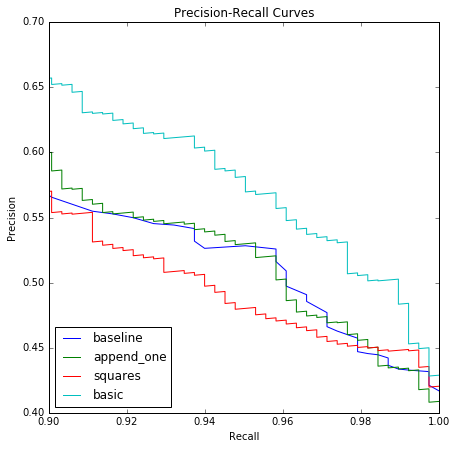

In [35]:
from sklearn.metrics import precision_recall_curve

data_empty = data_binarized = project_env.binarize(data, -1)
gold_labels = data_empty['dev'][1]

plt.figure(figsize=(7, 7))
pr_curve(data_empty['dev'][0]['num_docks_available_scaled'], 'baseline', gold_labels, target_recall=0.85)
for key in predictions_e.keys():
    pr_curve(predictions_e[key], key, gold_labels, target_recall=0.85)

format_plot(.85, empty=True)

Model baseline
  Max precision: 0.0496380558428 at recall 1.0
  Threshold of max precision: 0.016393442623
Model append_one
  Max precision: 0.427184466019 at recall 0.916666666667
  Threshold of max precision: 0.0109278638682
Model squares
  Max precision: 0.0538373424971 at recall 0.979166666667
  Threshold of max precision: 2.45502138432e-08
Model basic
  Max precision: 0.44 at recall 0.916666666667
  Threshold of max precision: 0.016966508998


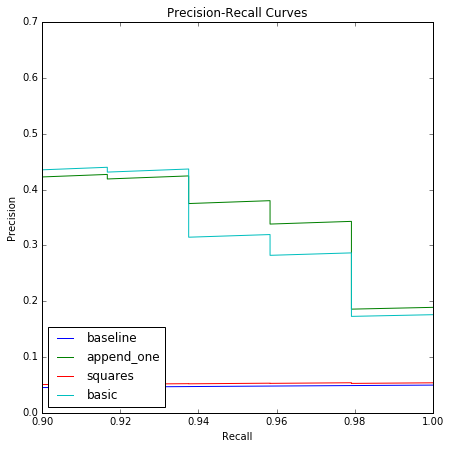

In [30]:
#data_full = data_binarized = project_env.binarize(data, 1)
gold_labels = data_full['dev'][1]
   
plt.figure(figsize=(7, 7))
pr_curve(data_full['dev'][0]['num_docks_available_scaled'], 'baseline', gold_labels, target_recall=0.95)
for key in predictions_f.keys():
    pr_curve(predictions_f[key], key, gold_labels, target_recall=0.85)

format_plot(.85, empty=False)

### Testing Different Target Variables

In [15]:
targets = ['y_10m','y_15m','y_30m','y_45m','y_60m','y_90m','y_120m']

datasets = dict.fromkeys(targets)

In [16]:
for target in targets:
    datasets[target] = project_env.load_split_bucket(519, target = target, log=False)

In [17]:
binarized_data_empty = dict.fromkeys(targets)
binarized_data_full = dict.fromkeys(targets)

In [18]:
for target in targets:
    binarized_data_empty[target] = project_env.binarize(datasets[target], -1)
    binarized_data_full[target] = project_env.binarize(datasets[target], 1)

In [19]:
logregs_empty = dict.fromkeys(targets)
scalers_empty = dict.fromkeys(targets)
predictions_empty = dict.fromkeys(targets)
logregs_full = dict.fromkeys(targets)
scalers_full = dict.fromkeys(targets)
predictions_full = dict.fromkeys(targets)

In [20]:
for target in targets:
    logregs_empty[target], scalers_empty[target], predictions_empty[target] = run_logreg.do_logreg(binarized_data_empty[target], plot = False)
    logregs_full[target], scalers_full[target], predictions_full[target] = run_logreg.do_logreg(binarized_data_full[target], plot = False)

X shape: (4289, 22)
Evaluating on dev set of 1002 examples
Accuracy: 0.89620758483
[[546  68]
 [ 36 352]]
X shape: (4289, 22)
Evaluating on dev set of 1002 examples
Accuracy: 0.957085828343
[[953   2]
 [ 41   6]]
X shape: (4257, 22)
Evaluating on dev set of 993 examples
Accuracy: 0.883182275932
[[516  81]
 [ 35 361]]
X shape: (4257, 22)
Evaluating on dev set of 993 examples
Accuracy: 0.952668680765
[[945   1]
 [ 46   1]]
X shape: (4298, 22)
Evaluating on dev set of 988 examples
Accuracy: 0.861336032389
[[499 102]
 [ 35 352]]
X shape: (4298, 22)
Evaluating on dev set of 988 examples
Accuracy: 0.952429149798
[[941   0]
 [ 47   0]]
X shape: (4228, 22)
Evaluating on dev set of 983 examples
Accuracy: 0.840284842319
[[481 120]
 [ 37 345]]
X shape: (4228, 22)
Evaluating on dev set of 983 examples
Accuracy: 0.951169888098
[[935   0]
 [ 48   0]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.810950413223
[[443 142]
 [ 41 342]]
X shape: (4236, 22)
Evaluating on dev set of 

### Evaluating Accuracy at Different Targets

#### 95% Recall Threshold

#### Empty

Model y_10m
  Max precision: 0.736526946108 at recall 0.951030927835
  Threshold of max precision: 0.117250850911
Model y_15m
  Max precision: 0.727799227799 at recall 0.95202020202
  Threshold of max precision: 0.166880407542
Model y_30m
  Max precision: 0.685288640596 at recall 0.950904392765
  Threshold of max precision: 0.25896608677
Model y_45m
  Max precision: 0.641342756184 at recall 0.950261780105
  Threshold of max precision: 0.30002509002
Model y_60m
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237075253857
Model y_90m
  Max precision: 0.55625 at recall 0.951871657754
  Threshold of max precision: 0.301549750887
Model y_120m
  Max precision: 0.553090332805 at recall 0.953551912568
  Threshold of max precision: 0.385048916308


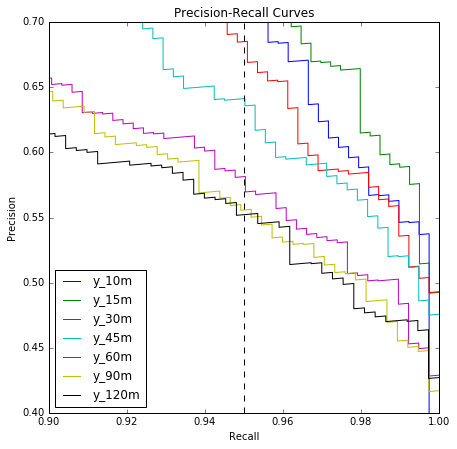

In [21]:
plt.figure(figsize=(7, 7))
for target in targets:
    pr_curve(predictions_empty[target], target, binarized_data_empty[target]['dev'][1])

format_plot(.95, empty = True)
plt.show() #the 60m one should be same as the first "basic", and it is

#### Full

Model y_10m
  Max precision: 0.671641791045 at recall 0.957446808511
  Threshold of max precision: 0.0846728322053
Model y_15m
  Max precision: 0.535714285714 at recall 0.957446808511
  Threshold of max precision: 0.0153294654791
Model y_30m
  Max precision: 0.40350877193 at recall 0.978723404255
  Threshold of max precision: 0.00591762609846
Model y_45m
  Max precision: 0.389830508475 at recall 0.958333333333
  Threshold of max precision: 0.0138377878306
Model y_60m
  Max precision: 0.319444444444 at recall 0.958333333333
  Threshold of max precision: 0.0084663560742
Model y_90m
  Max precision: 0.137380191693 at recall 0.955555555556
  Threshold of max precision: 0.0056386496408
Model y_120m
  Max precision: 0.100244498778 at recall 0.953488372093
  Threshold of max precision: 0.00371200215064


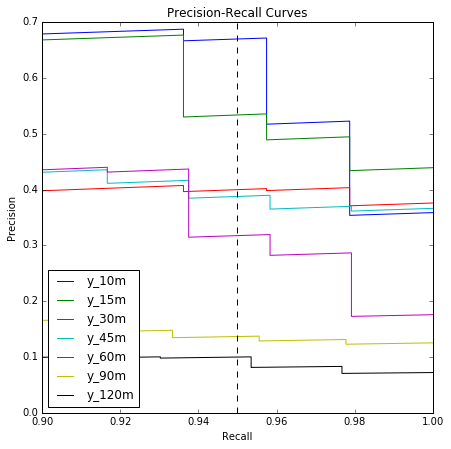

In [22]:
plt.figure(figsize=(7, 7))
for target in targets:
    pr_curve(predictions_full[target], target, binarized_data_full[target]['dev'][1])

format_plot(.95, empty=False)
plt.show()

#### Revised: 85% Recall Threshold

#### Empty

Model y_10m
  Max precision: 0.873015873016 at recall 0.850515463918
  Threshold of max precision: 0.691975389068
Model y_15m
  Max precision: 0.868894601542 at recall 0.853535353535
  Threshold of max precision: 0.689737862069
Model y_30m
  Max precision: 0.832911392405 at recall 0.850129198966
  Threshold of max precision: 0.673714133515
Model y_45m
  Max precision: 0.790754257908 at recall 0.850785340314
  Threshold of max precision: 0.636769876896
Model y_60m
  Max precision: 0.781774580336 at recall 0.851174934726
  Threshold of max precision: 0.637375427873
Model y_90m
  Max precision: 0.706666666667 at recall 0.850267379679
  Threshold of max precision: 0.546773310816
Model y_120m
  Max precision: 0.709090909091 at recall 0.852459016393
  Threshold of max precision: 0.569445110462


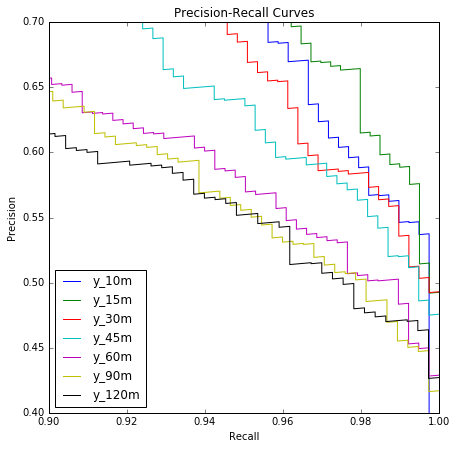

In [23]:
plt.figure(figsize=(7, 7))
for target in targets:
    pr_curve(predictions_empty[target], target, binarized_data_empty[target]['dev'][1], target_recall = .85)

format_plot(.85, empty = True)
plt.show() #the 60m one should be same as the first "basic", and it is

#### Full

Model y_10m
  Max precision: 0.736842105263 at recall 0.893617021277
  Threshold of max precision: 0.131802612746
Model y_15m
  Max precision: 0.740740740741 at recall 0.851063829787
  Threshold of max precision: 0.105078332305
Model y_30m
  Max precision: 0.481927710843 at recall 0.851063829787
  Threshold of max precision: 0.0173195964114
Model y_45m
  Max precision: 0.4375 at recall 0.875
  Threshold of max precision: 0.0263852729697
Model y_60m
  Max precision: 0.44 at recall 0.916666666667
  Threshold of max precision: 0.016966508998
Model y_90m
  Max precision: 0.167346938776 at recall 0.911111111111
  Threshold of max precision: 0.0080917361438
Model y_120m
  Max precision: 0.10393258427 at recall 0.860465116279
  Threshold of max precision: 0.00517027121416


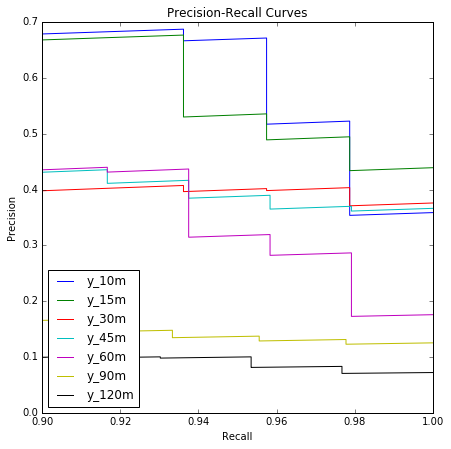

In [24]:
plt.figure(figsize=(7, 7))
for target in targets:
    pr_curve(predictions_full[target], target, binarized_data_full[target]['dev'][1], target_recall = .85)

format_plot(.85, empty=False)
plt.show()

#### Parameter Optimization

Trying different c-values and penalties

In [25]:
cvals = [.0001, .01, 1, 100, 10000, 1000000]
penalties = ['l1', 'l2']

In [26]:
cval_penalties = {}

for penalty in penalties:
    for c in cvals:
        cval_penalties['c: ' + str(int(c)) + '; loss: ' + penalty] = run_logreg.do_logreg(data_empty, plot=False, penalty=penalty, C=c)

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.604338842975
[[585   0]
 [383   0]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.786157024793
[[428 157]
 [ 50 333]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.813016528926
[[448 137]
 [ 44 339]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.809917355372
[[442 143]
 [ 41 342]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.809917355372
[[442 143]
 [ 41 342]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.809917355372
[[442 143]
 [ 41 342]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.696280991736
[[316 269]
 [ 25 358]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.77479338843
[[404 181]
 [ 37 346]]
X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.808884297521
[[442 143]
 [ 42 341]]
X shape: (4236, 22)
Evaluating on dev set of 96

In [27]:
cval_penalties['c: 100; loss: l1'][0]

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
cval_penalties['c: 100; loss: l1'][1]

StandardScaler(copy=True, with_mean=True, with_std=True)

Model c: 1000000; loss: l1
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.238252056986
Model c: 10000; loss: l1
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.238184290569
Model c: 1; loss: l1
  Max precision: 0.578696343402 at recall 0.950391644909
  Threshold of max precision: 0.267775248154
Model c: 100; loss: l2
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.238755342328
Model c: 1; loss: l2
  Max precision: 0.578696343402 at recall 0.950391644909
  Threshold of max precision: 0.270711263176
Model c: 10000; loss: l2
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237095807302
Model c: 0; loss: l2
  Max precision: 0.569640062598 at recall 0.950391644909
  Threshold of max precision: 0.367632738748
Model c: 1000000; loss: l2
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.2370788

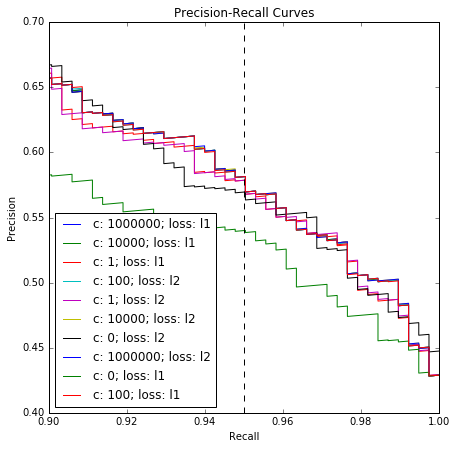

In [29]:
gold_labels = data_empty['dev'][1]

keys_list = list(cval_penalties.keys())
   
plt.figure(figsize=(7, 7))

for key in keys_list:
    pr_curve(cval_penalties[key][2], key, gold_labels, target_recall=0.95)

format_plot(.95, empty=True)

#### Average Accuracy of Several Stations

In [37]:
stations = list(stations_df.index)

In [38]:
'''modified pr_curve function to return the results instead of printing them and plotting them'''
def pr_curve_metrics(predictions, gold_labels, target_recall=0.95):
    curve = precision_recall_curve(gold_labels, predictions)
    precision, recall, thresholds = curve
    mp, mr, mt = project_env.max_precision_for_recall(curve, target_recall=target_recall)
    return mp, mr, mt

In [39]:
max_precision = dict.fromkeys(stations)
minimum_recall = dict.fromkeys(stations)
threshold_max_precision = dict.fromkeys(stations)

for station in stations:
    data = project_env.load_split_bucket(station, target='y_60m', log=False)
    data_empty = project_env.binarize(data, -1)
    try:
        logreg, scaler, dev_pred = run_logreg.do_logreg(data_empty, plot=False)
        max_precision[station], minimum_recall[station], threshold_max_precision[station] = pr_curve_metrics(dev_pred, data_empty['dev'][1])
    except ValueError:
        pass

X shape: (3113, 22)
Evaluating on dev set of 722 examples
Accuracy: 0.945983379501
[[681   6]
 [ 33   2]]
X shape: (3579, 22)
Evaluating on dev set of 799 examples
Accuracy: 0.917396745932
[[707  21]
 [ 45  26]]
X shape: (3064, 22)
Evaluating on dev set of 696 examples
Accuracy: 0.969827586207
[[675   1]
 [ 20   0]]
X shape: (3019, 22)
Evaluating on dev set of 729 examples
Accuracy: 0.851851851852
[[588  12]
 [ 96  33]]
X shape: (3314, 22)
Evaluating on dev set of 715 examples
Accuracy: 0.99020979021
[[708   7]
 [  0   0]]
X shape: (3585, 22)
Evaluating on dev set of 805 examples
Accuracy: 1.0
[[805]]
X shape: (4010, 22)
Evaluating on dev set of 971 examples
Accuracy: 0.97219361483
[[944  25]
 [  2   0]]
X shape: (3104, 22)
Evaluating on dev set of 739 examples
Accuracy: 0.983761840325
[[727   0]
 [ 12   0]]
X shape: (3027, 22)
Evaluating on dev set of 675 examples
Accuracy: 0.848888888889
[[557  54]
 [ 48  16]]
X shape: (3192, 22)
Evaluating on dev set of 755 examples
Accuracy: 0.8649

In [33]:
max_precision

#some have precision of 0 or none

{128: 0.048476454293628811,
 151: 0.37569060773480661,
 161: 0.17391304347826086,
 174: 0.33606557377049179,
 229: 0.0,
 284: 0.0,
 285: 0.003205128205128205,
 297: 0.5,
 320: 0.0,
 368: 0.18292682926829268,
 379: None,
 382: 0.0,
 383: 0.0,
 402: 0.29102167182662536,
 426: 0.10479041916167664,
 432: 0.32917705735660846,
 435: 0.33812949640287771,
 442: None,
 444: 0.45161290322580644,
 446: None,
 450: None,
 457: None,
 461: 0.52573529411764708,
 470: 0.27777777777777779,
 472: 0.55113636363636365,
 477: None,
 479: None,
 482: 0.23636363636363636,
 483: 0.14492753623188406,
 490: None,
 491: 0.729903536977492,
 492: None,
 494: None,
 497: 0.42028985507246375,
 504: 0.43360433604336046,
 505: None,
 507: 0.37004405286343611,
 509: 0.11398963730569948,
 511: 0.2662473794549266,
 518: 0.44773175542406313,
 519: 0.58146964856230032,
 523: None,
 527: 0.47424892703862659,
 531: 0.19727891156462585,
 540: 0.23099415204678361,
 3002: 0.14663461538461539,
 3141: 0.82334384858044163,
 3255:

In [34]:
minimum_recall

{128: 1.0,
 151: 0.95774647887323938,
 161: 1.0,
 174: 0.95348837209302328,
 229: nan,
 284: nan,
 285: 1.0,
 297: 1.0,
 320: nan,
 368: 1.0,
 379: None,
 382: nan,
 383: nan,
 402: 0.97409326424870468,
 426: 0.97222222222222221,
 432: 0.95652173913043481,
 435: 0.95918367346938771,
 442: None,
 444: 0.95238095238095233,
 446: None,
 450: None,
 457: None,
 461: 0.95973154362416102,
 470: 0.95238095238095233,
 472: 0.9509803921568627,
 477: None,
 479: None,
 482: 1.0,
 483: 0.95238095238095233,
 490: None,
 491: 0.95378151260504207,
 492: None,
 494: None,
 497: 0.96666666666666667,
 504: 0.95238095238095233,
 505: None,
 507: 0.95454545454545459,
 509: 0.95652173913043481,
 511: 0.95488721804511278,
 518: 0.95780590717299574,
 519: 0.95039164490861616,
 523: None,
 527: 0.95258620689655171,
 531: 0.98305084745762716,
 540: 0.95180722891566261,
 3002: 0.953125,
 3141: 0.95255474452554745,
 3255: None,
 3263: nan}

#### Closer look at ValueError

In [35]:
'''ValueError with some stations (like 379) occurrs in do_logreg at line dev_X_scaled = scaler.transform(dev_X)
This is because the result of load_split_bucket has nothing in the 'dev' or 'test' keys.
I couldn't figure out what was wrong trying to take the dataset through the process one step at a time.'''

"ValueError with some stations (like 379) occurrs in do_logreg at line dev_X_scaled = scaler.transform(dev_X)\nThis is because the result of load_split_bucket has nothing in the 'dev' or 'test' keys.\nI couldn't figure out what was wrong trying to take the dataset through the process one step at a time."

In [36]:
data = project_env.load_split_bucket(379, target='y_60m', log=False) #up here, dev and test are empty
data

{'dev': (Empty DataFrame
  Columns: [apparentTemperature, cloudCover, dewPoint, humidity, nearestStormDistance, ozone, precipIntensity, precipProbability, pressure, temperature, visibility, windBearing, windSpeed, num_bikes_available_scaled, num_bikes_disabled_scaled, num_docks_available_scaled, day_of_week, hour_of_day, is_weekend, traffic_0_speed_scrub, traffic_1_speed_scrub, traffic_2_speed_scrub]
  Index: []
  
  [0 rows x 22 columns], Series([], Name: y, dtype: float64)),
 'test': (Empty DataFrame
  Columns: [apparentTemperature, cloudCover, dewPoint, humidity, nearestStormDistance, ozone, precipIntensity, precipProbability, pressure, temperature, visibility, windBearing, windSpeed, num_bikes_available_scaled, num_bikes_disabled_scaled, num_docks_available_scaled, day_of_week, hour_of_day, is_weekend, traffic_0_speed_scrub, traffic_1_speed_scrub, traffic_2_speed_scrub]
  Index: []
  
  [0 rows x 22 columns], Series([], Name: y, dtype: float64)),
 'train': (      apparentTemperatur

In [ ]:
df = bucket_y_variable(load(229, mode='train', log=True), target = 'y_60m', threshold_empty = .1, threshold_full = .9, plot=True)